In [ ]:
import random
import os
import time
import json
from typing import Tuple, Dict, List
from sklearn.metrics import roc_auc_score, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')



import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler


try:
    from torchinfo import summary
except ImportError:
    !pip install torchinfo
    from torchinfo import summary


from PIL import Image


from tqdm.notebook import tqdm


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score,
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 4  
    EPOCHS = 50
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2
        else (32 * torch.cuda.device_count())
    )
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    DATASET_PATH = "/content/drive/My Drive/data_set/brain/Original_MRI"
    TRAIN_PATH = "/content/drive/My Drive/data_set/brain/Original_MRI/Training"
    TEST_PATH = "/content/drive/My Drive/data_set/brain/Original_MRI/Testing"


In [ ]:
import os
import pandas as pd


DATASET_PATH = "/content/drive/My Drive/data_set/brain/Original_MRI"
TRAIN_PATH = "/content/drive/My Drive/data_set/brain/Original_MRI/Training"
TEST_PATH = "/content/drive/My Drive/data_set/brain/Original_MRI/Testing"


def get_image_paths(base_path):
    image_paths = []
    for root, dirs, files in os.walk(base_path):  
        for file in files:
            if file.endswith(".jpg"):  
                image_paths.append(os.path.join(root, file))
    return image_paths


def generate_labels(image_paths):
    
    return [_.split('/')[-2].replace('-', '_') for _ in image_paths]


def build_df(image_paths, labels):
    
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    return df


train_images = get_image_paths(TRAIN_PATH)  
test_images = get_image_paths(TEST_PATH)   


train_df = build_df(train_images, train_images)
test_df = build_df(test_images, test_images)


print(train_df.head(5))


                                          image_path            label
0  /content/drive/My Drive/data_set/brain/Origina...  pituitary_tumor
1  /content/drive/My Drive/data_set/brain/Origina...  pituitary_tumor
2  /content/drive/My Drive/data_set/brain/Origina...  pituitary_tumor
3  /content/drive/My Drive/data_set/brain/Origina...  pituitary_tumor
4  /content/drive/My Drive/data_set/brain/Origina...  pituitary_tumor


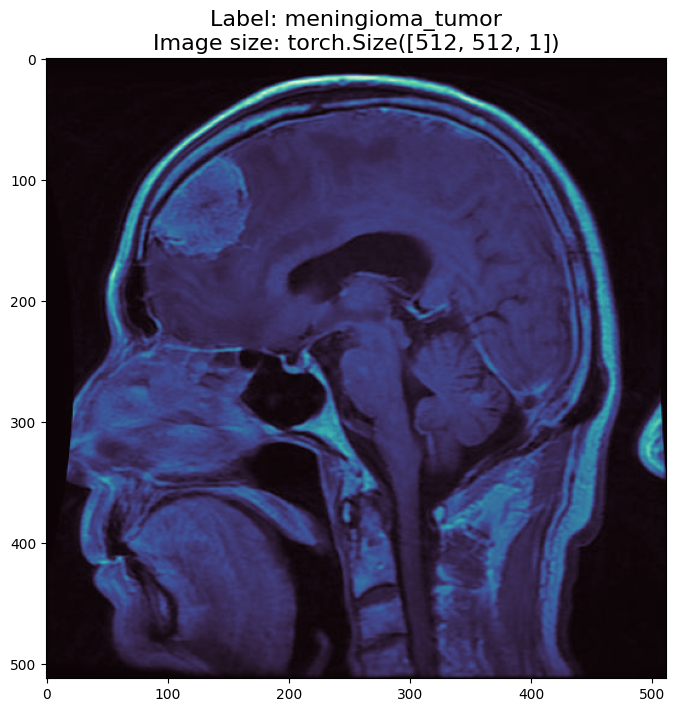

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms


def _load(image_path, as_tensor=True):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")

    image = Image.open(image_path)

    if as_tensor:
        converter = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale()
        ])
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)

    if color_map == 'rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)

    plt.title(f'Label: {label}\nImage size: {image.shape}', fontsize=16)
    return


idx = random.choice(train_df.index.to_list())


sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]


view_sample(
    sample_image.permute(1, 2, 0),  
    sample_label,
    color_map='mako',
)


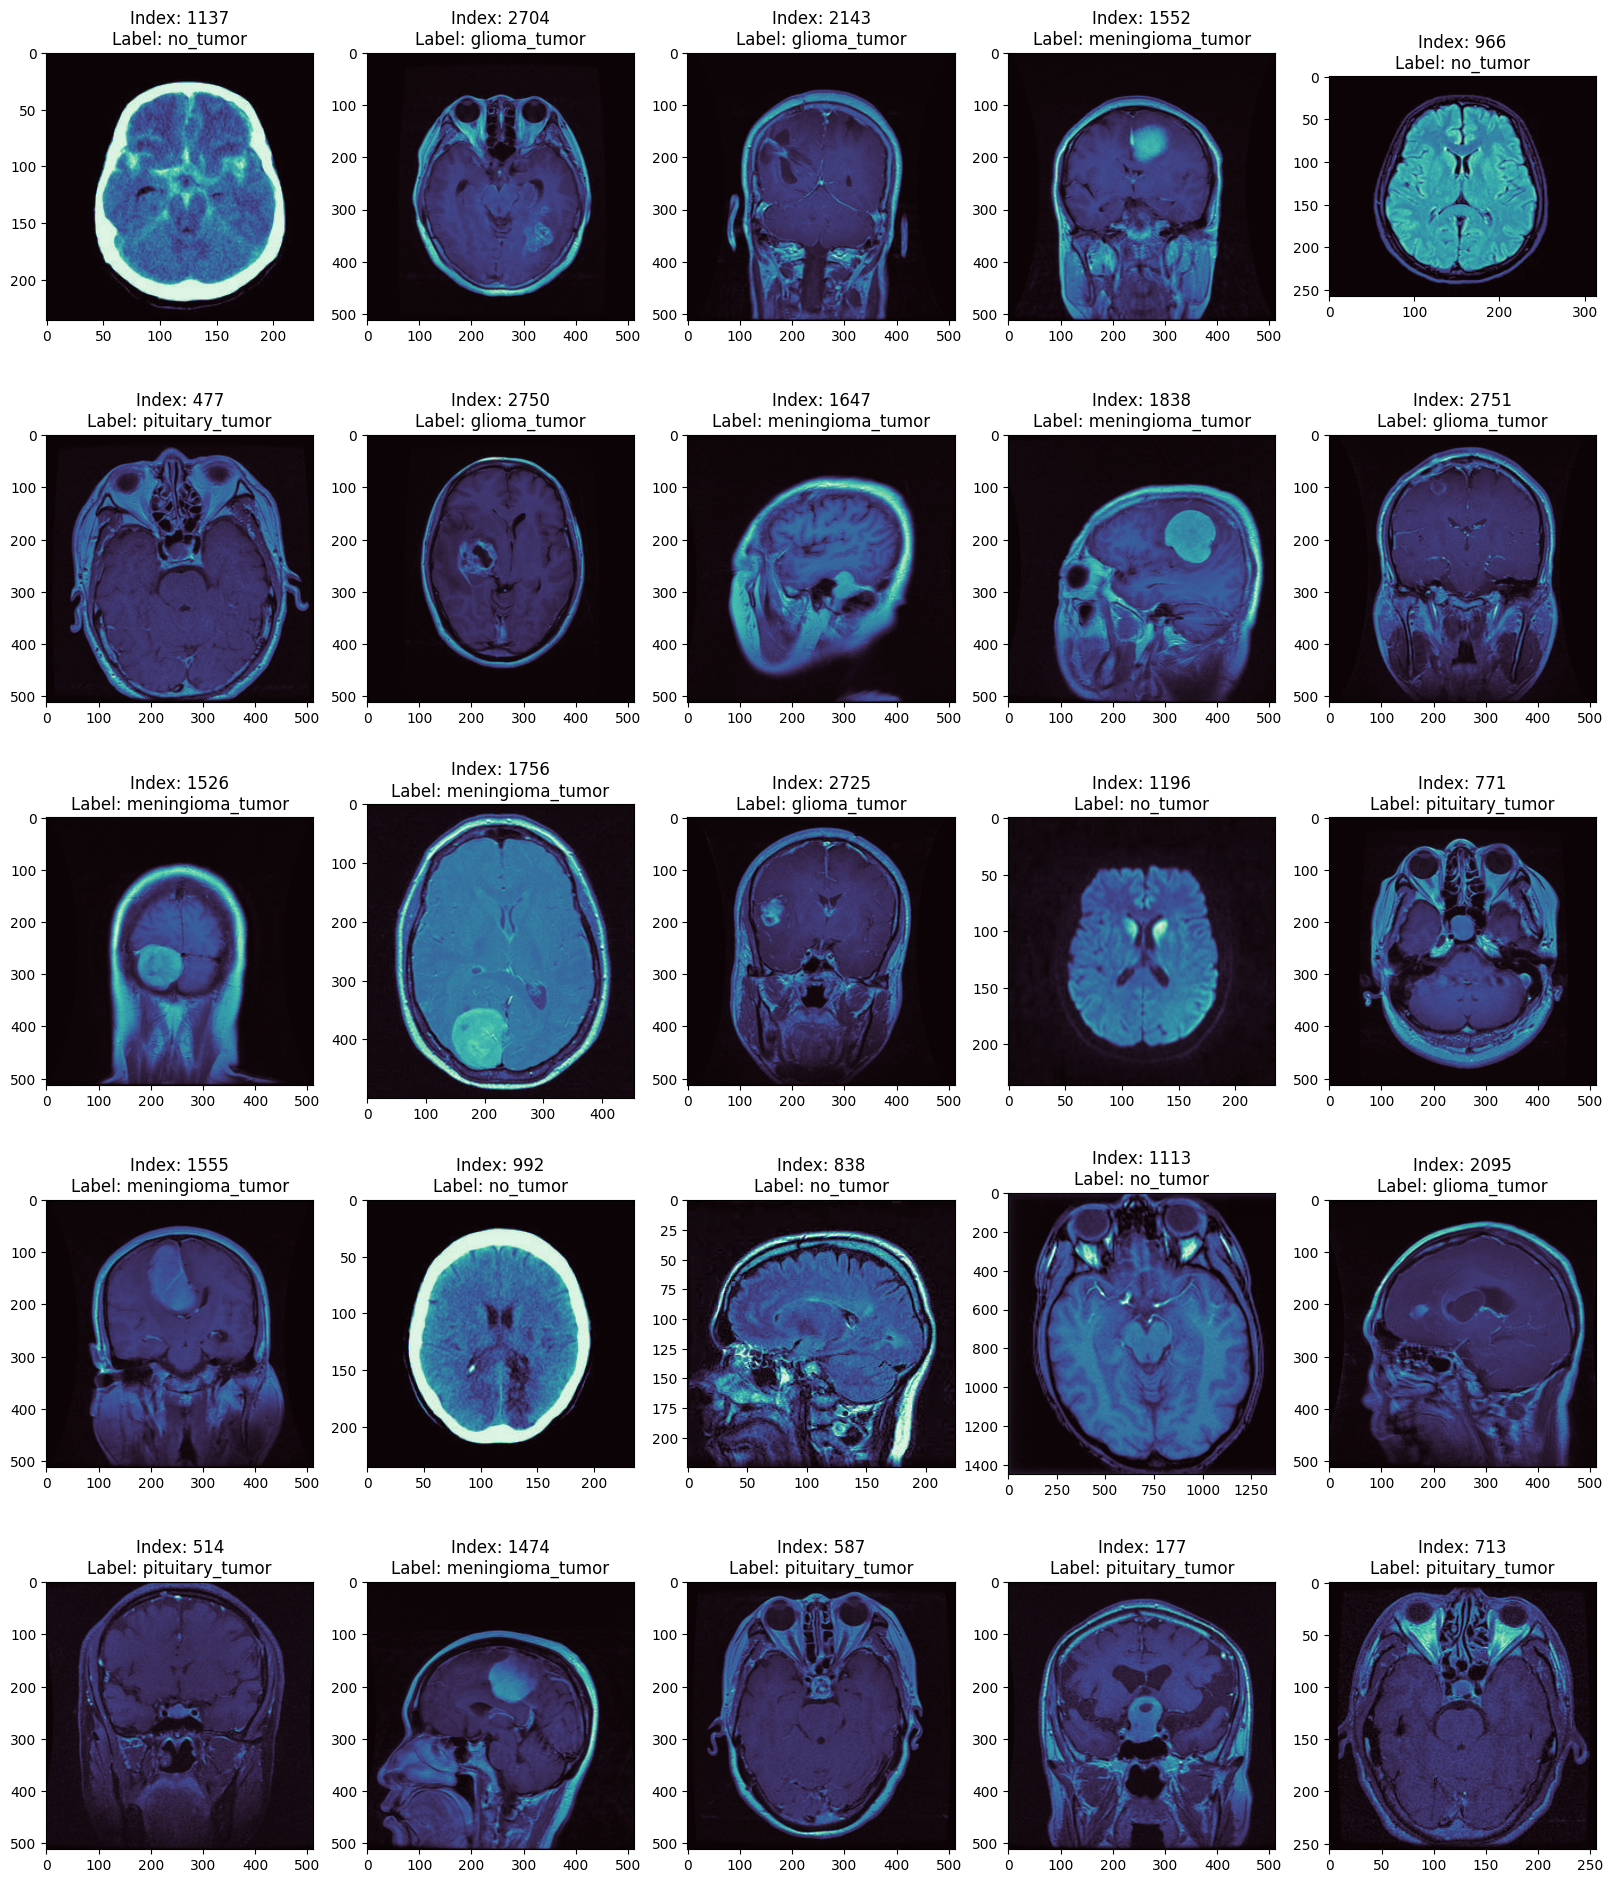

In [ ]:
import random
import matplotlib.pyplot as plt

def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
   
    if count > len(df):
        raise ValueError(f"Count ({count}) exceeds the number of samples in the DataFrame ({len(df)}).")

   
    columns = min(count, 5) 
    rows = (count + columns - 1) // columns  

    
    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, columns, column + 1)

        try:
            
            image = sample_loader(df.image_path[_])

           
            if color_map == 'rgb':
                plt.imshow(image.permute(1, 2, 0))
            else:
                plt.imshow(image.permute(1, 2, 0), cmap=color_map)

           
            plt.title(f'Index: {_}\nLabel: {df.label[_]}')
        except Exception as e:
            
            plt.text(0.5, 0.5, f"Error loading image\n{e}", ha='center', va='center')

    return


view_mulitiple_samples(
    train_df, _load,
    count=25, color_map='mako',
    fig_size=(20, 24)
)


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


TRAIN_PATH = "/content/drive/My Drive/data_set/brain/Original_MRI/Training"
TEST_PATH = "/content/drive/My Drive/data_set/brain/Original_MRI/Testing"


class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
        self.classes = sorted(self.dataframe['label'].unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

       
        image = Image.open(img_path).convert("RGB")

        
        if self.transform:
            image = self.transform(image)

       
        label_idx = self.class_to_idx[label]
        return image, torch.tensor(label_idx)


def load_data(data_path):
    images = []
    labels = []

    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        if os.path.isdir(label_path):  
            for image in os.listdir(label_path):
                images.append(os.path.join(label_path, image))
                labels.append(label)

    return pd.DataFrame({'image_path': images, 'label': labels})


train_df = load_data(TRAIN_PATH)


train_new_df, val_df = train_test_split(
    train_df,  
    test_size=0.20,  
    stratify=train_df['label'],  
    random_state=42  
)


train_new_df = train_new_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


test_df = load_data(TEST_PATH)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])


train_dataset = ImageDataset(train_new_df, transform=transform)
val_dataset = ImageDataset(val_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


train_size = len(train_new_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

print(f"Number of training set samples: {train_size} ({(100 * train_size / total):.2f}%)")
print(f"Number of validation set samples: {val_size} ({(100 * val_size / total):.2f}%)")
print(f"Number of test set samples: {test_size} ({(100 * test_size / total):.2f}%)")
print("===================================")
print(f"Total number of samples: {total} ({(100 * total / total):.2f}%)")


In [ ]:
transform = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label'], random_state=42
)
train_new_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_dataset = ImageDataset(train_new_df, transform=transform)
val_dataset = ImageDataset(val_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)


class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large',
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2Model, self).__init__()

        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name

        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)

        self._set_classifier(classifier)

    def _set_classifier(self, classifier: nn.Module) -> None:
        self.backbone_model.classifier = classifier

    def forward(self, image):
        return self.backbone_model(image)

def get_effiecientnetv2_model(device: torch.device = CFG.DEVICE) -> nn.Module:
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    model_weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_l(weights=model_weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    return model

backbone_model = get_effiecientnetv2_model(CFG.DEVICE)
efficientnet_model = EfficientNetV2Model(backbone_model, device=CFG.DEVICE)

if CFG.NUM_DEVICES > 1:
    efficientnet_model = nn.DataParallel(efficientnet_model)

summary(
    model=efficientnet_model,
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.HEIGHT, CFG.WIDTH),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
EfficientNetV2Model (EfficientNetV2Model)                         [32, 3, 224, 224]    [32, 4]              --                   Partial
├─EfficientNet (backbone_model)                                   [32, 3, 224, 224]    [32, 4]              --                   Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 32, 112, 112]   (37,120)             False
│    │    └─Sequential (2)                                        [32, 32, 112, 112]   [32, 64, 56, 56]     (1,032,320)          False
│    │    └─Sequential (3)                     

In [20]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer
optimizer = torch.optim.AdamW(
    efficientnet_model.parameters(),
    lr=CFG.LR
)

In [21]:
def execute_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [22]:
def evaluate(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.eval()
    eval_loss, eval_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()

            predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

    eval_loss /= len(dataloader)
    eval_acc /= len(dataloader)

    return eval_loss, eval_acc

In [ ]:
def train_with_metrics(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    eval_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    num_classes: int
) -> Dict[str, List]:
    session = {
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'sensitivity': [],
        'specificity': [],
        'f1_score': [],
        'roc_auc': [],
        'eval_loss': [],
        'eval_accuracy': []
    }

    best_epoch_metrics = None 

    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model,
            train_dataloader,
            optimizer,
            loss_fn,
            device
        )

        eval_loss, eval_acc = evaluate(
            model,
            eval_dataloader,
            loss_fn,
            device
        )

      
        y_true = []
        y_pred = []
        y_probs = []

        for X, y in eval_dataloader:
            X, y = X.to(device), y.to(device)
            with torch.inference_mode():
                preds = model(X)
                y_probs.append(torch.softmax(preds, dim=1).cpu().numpy())
                y_true.extend(y.cpu().numpy())
                y_pred.extend(torch.argmax(preds, dim=1).cpu().numpy())

        y_probs = np.vstack(y_probs)

      
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
        sensitivity, specificity = compute_sensitivity_specificity(y_true, y_pred, num_classes)
        roc_auc = roc_auc_score(
            y_true, y_probs, multi_class="ovr", average="weighted"
        )

        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        print(f'Precision: {precision:.4f} - Recall: {recall:.4f} - Sensitivity: {sensitivity:.4f} - Specificity: {specificity:.4f}')
        print(f'F1-Score: {f1:.4f} - ROC AUC: {roc_auc:.4f}')

      
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuracy'].append(eval_acc)
        session['precision'].append(precision)
        session['recall'].append(recall)
        session['sensitivity'].append(sensitivity)
        session['specificity'].append(specificity)
        session['f1_score'].append(f1)
        session['roc_auc'].append(roc_auc)

       
        if not best_epoch_metrics or eval_acc > best_epoch_metrics['eval_accuracy']:
            best_epoch_metrics = {
                "epoch": epoch + 1,
                "loss": train_loss,
                "accuracy": train_acc,
                "eval_loss": eval_loss,
                "eval_accuracy": eval_acc,
                "precision": precision,
                "recall": recall,
                "sensitivity": sensitivity,
                "specificity": specificity,
                "f1_score": f1,
                "roc_auc": roc_auc
            }

    print(f"\nBest Epoch Metrics (Epoch {best_epoch_metrics['epoch']}):")
    for metric, value in best_epoch_metrics.items():
        if metric != "epoch":
            print(f"{metric.capitalize()}: {value:.4f}")

    return session, best_epoch_metrics

In [ ]:
# # Train the model
# print('Training EfficientNet Model')
# print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
# print('----------------------------------')

# efficientnet_session_config = {
#     'model': efficientnet_model,
#     'train_dataloader': train_loader,
#     'eval_dataloader': val_loader,
#     'optimizer': optimizer,
#     'loss_fn': loss_fn,
#     'epochs': CFG.EPOCHS,
#     'device': CFG.DEVICE
# }

# efficientnet_session_history = train(**efficientnet_session_config)


# import json


# save_history_path = '/content/drive/My Drive/data_set/brain/Train_model/Baseline/training_history.json'


# with open(save_history_path, 'w') as f:
#     json.dump(efficientnet_session_history, f)

# print(f'Training history saved to {save_history_path}')


# import torch

# save_model_path = '/content/drive/My Drive/data_set/brain/Train_model/Baseline/efficientnet_model.pth'
# torch.save(efficientnet_model.state_dict(), save_model_path)

# print(f'Model weights saved to {save_model_path}')

In [ ]:

class VisionTransformerModel(nn.Module):
    def __init__(self, backbone_model, name='vision-transformer',
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(VisionTransformerModel, self).__init__()

        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1000, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)

    def forward(self, image):
        vit_output = self.backbone_model(image)
        return self.classifier(vit_output)


In [25]:
def get_vit_b32_model(device: torch.device = CFG.DEVICE) -> nn.Module:
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    model_weights = torchvision.models.ViT_B_32_Weights.DEFAULT
    model = torchvision.models.vit_b_32(weights=model_weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    return model

In [26]:
vit_backbone = get_vit_b32_model(CFG.DEVICE)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:01<00:00, 228MB/s]


In [27]:
vit_model = VisionTransformerModel(vit_backbone, device=CFG.DEVICE)

if CFG.NUM_DEVICES > 1:
    vit_model = nn.DataParallel(vit_model)

In [ ]:

summary(
    model=vit_model,
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.HEIGHT, CFG.WIDTH),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
VisionTransformerModel (VisionTransformerModel)                   [32, 3, 224, 224]    [32, 4]              --                   Partial
├─VisionTransformer (backbone_model)                              [32, 3, 224, 224]    [32, 1000]           768                  False
│    └─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 7, 7]      (2,360,064)          False
│    └─Encoder (encoder)                                          [32, 50, 768]        [32, 50, 768]        38,400               False
│    │    └─Dropout (dropout)                                     [32, 50, 768]        [32, 50, 768]        --                   --
│    │    └─Sequential (layers)                                   [32, 50, 768]        [32, 50, 768]        (85,054,464)         False
│    │    └─LayerNorm (ln)                          

In [ ]:

vit_loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

vit_optimizer = torch.optim.AdamW(
    vit_model.parameters(),
    lr=CFG.LR
)

In [30]:
def compute_sensitivity_specificity(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    sensitivity = []
    specificity = []

    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    return np.mean(sensitivity), np.mean(specificity)


In [ ]:

print('Training Vision Transformer Model')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vit_session_history, vit_best_metrics = train_with_metrics(
    model=vit_model,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    optimizer=vit_optimizer,
    loss_fn=vit_loss_fn,
    epochs=CFG.EPOCHS,
    device=CFG.DEVICE,
    num_classes=CFG.NUM_CLASSES
)


save_vit_history_path = '/content/drive/My Drive/data_set/brain/Train_model/Baseline/vit_training_history_with_metrics.json'

with open(save_vit_history_path, 'w') as f:
    json.dump(vit_session_history, f)

print(f'Vision Transformer training history saved to {save_vit_history_path}')


save_vit_best_metrics_path = '/content/drive/My Drive/data_set/brain/Train_model/Baseline/vit_best_metrics.json'

with open(save_vit_best_metrics_path, 'w') as f:
    json.dump(vit_best_metrics, f)

print(f'Best Vision Transformer metrics saved to {save_vit_best_metrics_path}')


save_vit_model_path = '/content/drive/My Drive/data_set/brain/Train_model/Baseline/vit_model_with_metrics.pth'
torch.save(vit_model.state_dict(), save_vit_model_path)

print(f'Vision Transformer model weights saved to {save_vit_model_path}')

Training Vision Transformer Model
Train on 2296 samples, validate on 574 samples.
----------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.8589 - acc: 0.7231 - eval_loss: 0.7153 - eval_acc: 0.8295
Precision: 0.8289 - Recall: 0.8293 - Sensitivity: 0.8301 - Specificity: 0.9411
F1-Score: 0.8288 - ROC AUC: 0.9530

Epoch 2/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.6611 - acc: 0.8520 - eval_loss: 0.6833 - eval_acc: 0.8258
Precision: 0.8478 - Recall: 0.8258 - Sensitivity: 0.8155 - Specificity: 0.9394
F1-Score: 0.8255 - ROC AUC: 0.9662

Epoch 3/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.6181 - acc: 0.8725 - eval_loss: 0.6311 - eval_acc: 0.8730
Precision: 0.8769 - Recall: 0.8728 - Sensitivity: 0.8778 - Specificity: 0.9563
F1-Score: 0.8731 - ROC AUC: 0.9714

Epoch 4/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.5863 - acc: 0.8903 - eval_loss: 0.6090 - eval_acc: 0.8851
Precision: 0.8874 - Recall: 0.8850 - Sensitivity: 0.8868 - Specificity: 0.9603
F1-Score: 0.8858 - ROC AUC: 0.9765

Epoch 5/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.5562 - acc: 0.9093 - eval_loss: 0.6123 - eval_acc: 0.8728
Precision: 0.8742 - Recall: 0.8728 - Sensitivity: 0.8696 - Specificity: 0.9564
F1-Score: 0.8727 - ROC AUC: 0.9781

Epoch 6/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.5364 - acc: 0.9227 - eval_loss: 0.5995 - eval_acc: 0.8747
Precision: 0.8757 - Recall: 0.8746 - Sensitivity: 0.8711 - Specificity: 0.9564
F1-Score: 0.8745 - ROC AUC: 0.9768

Epoch 7/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.5065 - acc: 0.9353 - eval_loss: 0.5894 - eval_acc: 0.8991
Precision: 0.9020 - Recall: 0.8990 - Sensitivity: 0.9022 - Specificity: 0.9654
F1-Score: 0.8997 - ROC AUC: 0.9800

Epoch 8/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4950 - acc: 0.9484 - eval_loss: 0.5761 - eval_acc: 0.9061
Precision: 0.9062 - Recall: 0.9059 - Sensitivity: 0.9066 - Specificity: 0.9674
F1-Score: 0.9059 - ROC AUC: 0.9814

Epoch 9/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4883 - acc: 0.9531 - eval_loss: 0.5840 - eval_acc: 0.8796
Precision: 0.8841 - Recall: 0.8798 - Sensitivity: 0.8790 - Specificity: 0.9582
F1-Score: 0.8782 - ROC AUC: 0.9840

Epoch 10/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4697 - acc: 0.9666 - eval_loss: 0.5785 - eval_acc: 0.8922
Precision: 0.8922 - Recall: 0.8920 - Sensitivity: 0.8945 - Specificity: 0.9631
F1-Score: 0.8913 - ROC AUC: 0.9823

Epoch 11/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4604 - acc: 0.9735 - eval_loss: 0.5842 - eval_acc: 0.8903
Precision: 0.8944 - Recall: 0.8902 - Sensitivity: 0.8897 - Specificity: 0.9620
F1-Score: 0.8895 - ROC AUC: 0.9849

Epoch 12/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4550 - acc: 0.9757 - eval_loss: 0.5855 - eval_acc: 0.8939
Precision: 0.8944 - Recall: 0.8937 - Sensitivity: 0.8944 - Specificity: 0.9638
F1-Score: 0.8940 - ROC AUC: 0.9802

Epoch 13/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4507 - acc: 0.9770 - eval_loss: 0.5742 - eval_acc: 0.9044
Precision: 0.9044 - Recall: 0.9042 - Sensitivity: 0.9018 - Specificity: 0.9670
F1-Score: 0.9042 - ROC AUC: 0.9812

Epoch 14/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4414 - acc: 0.9831 - eval_loss: 0.5768 - eval_acc: 0.9025
Precision: 0.9034 - Recall: 0.9024 - Sensitivity: 0.9053 - Specificity: 0.9670
F1-Score: 0.9012 - ROC AUC: 0.9838

Epoch 15/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4423 - acc: 0.9792 - eval_loss: 0.5590 - eval_acc: 0.9044
Precision: 0.9045 - Recall: 0.9042 - Sensitivity: 0.9018 - Specificity: 0.9668
F1-Score: 0.9036 - ROC AUC: 0.9850

Epoch 16/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4340 - acc: 0.9838 - eval_loss: 0.5635 - eval_acc: 0.9044
Precision: 0.9083 - Recall: 0.9042 - Sensitivity: 0.8985 - Specificity: 0.9666
F1-Score: 0.9048 - ROC AUC: 0.9834

Epoch 17/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4305 - acc: 0.9861 - eval_loss: 0.5619 - eval_acc: 0.9009
Precision: 0.9006 - Recall: 0.9007 - Sensitivity: 0.8988 - Specificity: 0.9657
F1-Score: 0.9005 - ROC AUC: 0.9833

Epoch 18/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4194 - acc: 0.9926 - eval_loss: 0.5564 - eval_acc: 0.9061
Precision: 0.9062 - Recall: 0.9059 - Sensitivity: 0.9017 - Specificity: 0.9673
F1-Score: 0.9056 - ROC AUC: 0.9851

Epoch 19/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4170 - acc: 0.9931 - eval_loss: 0.5566 - eval_acc: 0.9061
Precision: 0.9058 - Recall: 0.9059 - Sensitivity: 0.9066 - Specificity: 0.9678
F1-Score: 0.9056 - ROC AUC: 0.9857

Epoch 20/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4134 - acc: 0.9939 - eval_loss: 0.5627 - eval_acc: 0.9078
Precision: 0.9077 - Recall: 0.9077 - Sensitivity: 0.9082 - Specificity: 0.9687
F1-Score: 0.9071 - ROC AUC: 0.9836

Epoch 21/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4184 - acc: 0.9935 - eval_loss: 0.5481 - eval_acc: 0.9164
Precision: 0.9168 - Recall: 0.9164 - Sensitivity: 0.9141 - Specificity: 0.9713
F1-Score: 0.9165 - ROC AUC: 0.9859

Epoch 22/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4149 - acc: 0.9944 - eval_loss: 0.5552 - eval_acc: 0.9093
Precision: 0.9114 - Recall: 0.9094 - Sensitivity: 0.9014 - Specificity: 0.9685
F1-Score: 0.9097 - ROC AUC: 0.9849

Epoch 23/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4144 - acc: 0.9907 - eval_loss: 0.5699 - eval_acc: 0.9112
Precision: 0.9124 - Recall: 0.9111 - Sensitivity: 0.9112 - Specificity: 0.9698
F1-Score: 0.9098 - ROC AUC: 0.9837

Epoch 24/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4107 - acc: 0.9973 - eval_loss: 0.5467 - eval_acc: 0.9198
Precision: 0.9200 - Recall: 0.9199 - Sensitivity: 0.9171 - Specificity: 0.9725
F1-Score: 0.9194 - ROC AUC: 0.9869

Epoch 25/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4108 - acc: 0.9957 - eval_loss: 0.5579 - eval_acc: 0.9112
Precision: 0.9109 - Recall: 0.9111 - Sensitivity: 0.9095 - Specificity: 0.9695
F1-Score: 0.9106 - ROC AUC: 0.9836

Epoch 26/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4079 - acc: 0.9952 - eval_loss: 0.5408 - eval_acc: 0.9234
Precision: 0.9236 - Recall: 0.9233 - Sensitivity: 0.9218 - Specificity: 0.9735
F1-Score: 0.9234 - ROC AUC: 0.9861

Epoch 27/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4056 - acc: 0.9978 - eval_loss: 0.5477 - eval_acc: 0.9043
Precision: 0.9046 - Recall: 0.9042 - Sensitivity: 0.9018 - Specificity: 0.9668
F1-Score: 0.9041 - ROC AUC: 0.9861

Epoch 28/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4076 - acc: 0.9961 - eval_loss: 0.5524 - eval_acc: 0.9006
Precision: 0.9049 - Recall: 0.9007 - Sensitivity: 0.8988 - Specificity: 0.9658
F1-Score: 0.9008 - ROC AUC: 0.9864

Epoch 29/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4049 - acc: 0.9957 - eval_loss: 0.5433 - eval_acc: 0.9166
Precision: 0.9160 - Recall: 0.9164 - Sensitivity: 0.9141 - Specificity: 0.9715
F1-Score: 0.9161 - ROC AUC: 0.9865

Epoch 30/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4068 - acc: 0.9957 - eval_loss: 0.5429 - eval_acc: 0.9251
Precision: 0.9251 - Recall: 0.9251 - Sensitivity: 0.9233 - Specificity: 0.9744
F1-Score: 0.9250 - ROC AUC: 0.9854

Epoch 31/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4026 - acc: 0.9961 - eval_loss: 0.5345 - eval_acc: 0.9216
Precision: 0.9216 - Recall: 0.9216 - Sensitivity: 0.9153 - Specificity: 0.9731
F1-Score: 0.9215 - ROC AUC: 0.9872

Epoch 32/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4012 - acc: 0.9970 - eval_loss: 0.5364 - eval_acc: 0.9252
Precision: 0.9255 - Recall: 0.9251 - Sensitivity: 0.9217 - Specificity: 0.9741
F1-Score: 0.9251 - ROC AUC: 0.9880

Epoch 33/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4009 - acc: 0.9952 - eval_loss: 0.5375 - eval_acc: 0.9199
Precision: 0.9202 - Recall: 0.9199 - Sensitivity: 0.9188 - Specificity: 0.9726
F1-Score: 0.9197 - ROC AUC: 0.9875

Epoch 34/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4019 - acc: 0.9983 - eval_loss: 0.5299 - eval_acc: 0.9218
Precision: 0.9221 - Recall: 0.9216 - Sensitivity: 0.9170 - Specificity: 0.9727
F1-Score: 0.9215 - ROC AUC: 0.9878

Epoch 35/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3985 - acc: 0.9991 - eval_loss: 0.5434 - eval_acc: 0.9235
Precision: 0.9237 - Recall: 0.9233 - Sensitivity: 0.9201 - Specificity: 0.9734
F1-Score: 0.9232 - ROC AUC: 0.9855

Epoch 36/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3989 - acc: 0.9957 - eval_loss: 0.5514 - eval_acc: 0.9130
Precision: 0.9130 - Recall: 0.9129 - Sensitivity: 0.9127 - Specificity: 0.9699
F1-Score: 0.9126 - ROC AUC: 0.9853

Epoch 37/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4005 - acc: 0.9965 - eval_loss: 0.5393 - eval_acc: 0.9183
Precision: 0.9177 - Recall: 0.9181 - Sensitivity: 0.9156 - Specificity: 0.9719
F1-Score: 0.9177 - ROC AUC: 0.9861

Epoch 38/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.4005 - acc: 0.9957 - eval_loss: 0.5297 - eval_acc: 0.9321
Precision: 0.9319 - Recall: 0.9321 - Sensitivity: 0.9294 - Specificity: 0.9770
F1-Score: 0.9319 - ROC AUC: 0.9885

Epoch 39/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3986 - acc: 0.9974 - eval_loss: 0.5444 - eval_acc: 0.9251
Precision: 0.9255 - Recall: 0.9251 - Sensitivity: 0.9217 - Specificity: 0.9745
F1-Score: 0.9247 - ROC AUC: 0.9873

Epoch 40/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3990 - acc: 0.9987 - eval_loss: 0.5426 - eval_acc: 0.9111
Precision: 0.9110 - Recall: 0.9111 - Sensitivity: 0.9095 - Specificity: 0.9695
F1-Score: 0.9110 - ROC AUC: 0.9856

Epoch 41/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3949 - acc: 0.9987 - eval_loss: 0.5297 - eval_acc: 0.9199
Precision: 0.9219 - Recall: 0.9199 - Sensitivity: 0.9188 - Specificity: 0.9723
F1-Score: 0.9202 - ROC AUC: 0.9886

Epoch 42/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3961 - acc: 0.9983 - eval_loss: 0.5214 - eval_acc: 0.9301
Precision: 0.9310 - Recall: 0.9303 - Sensitivity: 0.9262 - Specificity: 0.9762
F1-Score: 0.9306 - ROC AUC: 0.9895

Epoch 43/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3926 - acc: 0.9983 - eval_loss: 0.5296 - eval_acc: 0.9355
Precision: 0.9360 - Recall: 0.9355 - Sensitivity: 0.9340 - Specificity: 0.9780
F1-Score: 0.9357 - ROC AUC: 0.9870

Epoch 44/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3923 - acc: 0.9983 - eval_loss: 0.5339 - eval_acc: 0.9199
Precision: 0.9207 - Recall: 0.9199 - Sensitivity: 0.9188 - Specificity: 0.9725
F1-Score: 0.9201 - ROC AUC: 0.9872

Epoch 45/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3935 - acc: 0.9978 - eval_loss: 0.5320 - eval_acc: 0.9147
Precision: 0.9143 - Recall: 0.9146 - Sensitivity: 0.9142 - Specificity: 0.9707
F1-Score: 0.9143 - ROC AUC: 0.9877

Epoch 46/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3970 - acc: 0.9970 - eval_loss: 0.5603 - eval_acc: 0.9096
Precision: 0.9109 - Recall: 0.9094 - Sensitivity: 0.9113 - Specificity: 0.9689
F1-Score: 0.9076 - ROC AUC: 0.9875

Epoch 47/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3900 - acc: 0.9996 - eval_loss: 0.5358 - eval_acc: 0.9163
Precision: 0.9180 - Recall: 0.9164 - Sensitivity: 0.9124 - Specificity: 0.9712
F1-Score: 0.9169 - ROC AUC: 0.9868

Epoch 48/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3908 - acc: 0.9987 - eval_loss: 0.5364 - eval_acc: 0.9216
Precision: 0.9218 - Recall: 0.9216 - Sensitivity: 0.9137 - Specificity: 0.9729
F1-Score: 0.9211 - ROC AUC: 0.9882

Epoch 49/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3907 - acc: 0.9996 - eval_loss: 0.5296 - eval_acc: 0.9181
Precision: 0.9183 - Recall: 0.9181 - Sensitivity: 0.9172 - Specificity: 0.9717
F1-Score: 0.9181 - ROC AUC: 0.9884

Epoch 50/50


  0%|          | 0/72 [00:00<?, ?it/s]

loss: 0.3946 - acc: 0.9970 - eval_loss: 0.5364 - eval_acc: 0.9147
Precision: 0.9147 - Recall: 0.9146 - Sensitivity: 0.9142 - Specificity: 0.9705
F1-Score: 0.9140 - ROC AUC: 0.9886

Best Epoch Metrics (Epoch 43):
Loss: 0.3926
Accuracy: 0.9983
Eval_loss: 0.5296
Eval_accuracy: 0.9355
Precision: 0.9360
Recall: 0.9355
Sensitivity: 0.9340
Specificity: 0.9780
F1_score: 0.9357
Roc_auc: 0.9870
Vision Transformer training history saved to /content/drive/My Drive/data_set/brain/Train_model/Baseline/vit_training_history_with_metrics.json
Best Vision Transformer metrics saved to /content/drive/My Drive/data_set/brain/Train_model/Baseline/vit_best_metrics.json
Vision Transformer model weights saved to /content/drive/My Drive/data_set/brain/Train_model/Baseline/vit_model_with_metrics.pth


In [ ]:

print("Starting Performance Analysis...")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
)


test_labels = [test_dataset.class_to_idx[label] for label in test_df['label']]



def predict(model, dataloader, device):
    model.eval()
    predictions = []
    probabilities = []

    with torch.inference_mode():
        for X, _ in dataloader:
            X = X.to(device)
            y_pred = model(X)
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            predicted_classes = np.argmax(predicted_probs, axis=1)

            probabilities.append(predicted_probs)
            predictions.extend(predicted_classes)

    return np.array(predictions), np.vstack(probabilities)


vit_test_preds, vit_test_probs = predict(vit_model, test_loader, CFG.DEVICE)


vit_test_sensitivity, vit_test_specificity = compute_sensitivity_specificity(
    test_labels, vit_test_preds, CFG.NUM_CLASSES
)
vit_test_roc_auc = roc_auc_score(
    test_labels, vit_test_probs, multi_class="ovr", average="weighted"
)



def plot_confusion_matrix(y_true, y_pred, classes, figsize=(10, 10)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(test_labels, vit_test_preds, test_dataset.classes)


print("\nClassification Report:")
print(
    classification_report(
        test_labels, vit_test_preds, target_names=test_dataset.classes
    )
)


def plot_roc_curve(y_true, y_probs, classes, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(np.array(test_labels), vit_test_probs, test_dataset.classes)


def record_performance_metrics(y_true, y_pred, y_probs, num_classes):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )
    sensitivity, specificity = compute_sensitivity_specificity(y_true, y_pred, num_classes)
    roc_auc = roc_auc_score(y_true, y_probs, multi_class="ovr", average="weighted")
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "F1-Score": f1,
        "ROC AUC": roc_auc,
    }
    return metrics


vit_metrics = record_performance_metrics(
    test_labels, vit_test_preds, vit_test_probs, CFG.NUM_CLASSES
)


print("\nPerformance Metrics:")
for metric, value in vit_metrics.items():
    print(f"{metric}: {value:.4f}")


save_vit_metrics_path = '/content/drive/My Drive/data_set/brain/Train_model/Baseline/vit_test_metrics.json'

with open(save_vit_metrics_path, 'w') as f:
    json.dump(vit_metrics, f)

print(f'Vision Transformer test metrics saved to {save_vit_metrics_path}')

Starting Performance Analysis...
